In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

# 推論を実行する

In [2]:
from utils.ssd_model import SSD

voc_classes = ['safe', 'caution']

# SSD300の設定
ssd_cfg = {
    'num_classes': 3,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)




# SSDの学習済みの重みを設定(ここは場合によって変更)
net_weights = torch.load('./weights/fine_tuning_32batch/ssd300_fine260.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


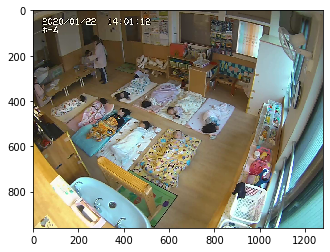

torch.Size([1, 3, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.7778, 0.4522, 0.4285, 0.5272, 0.5086],
          [0.3833, 0.4641, 0.5348, 0.5287, 0.6127],
          [0.3204, 0.2680, 0.4427, 0.3401, 0.5107],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.7622, 0.5699, 0.4882, 0.6520, 0.5762],
          [0.5454, 0.3559, 0.3855, 0.4281, 0.4566],
          [0.5353, 0.2697, 0.3494, 0.3383, 0.4248],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.000

..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [3]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
#image_file_path = "../data/10588044_01.jpg"
image_file_path = "../data/annotation_data/train_anotation/sleeping_check-PascalVOC-export/JPEGImages/10588044_01.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])  今回1枚だけなので、batch_num=1
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）


..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


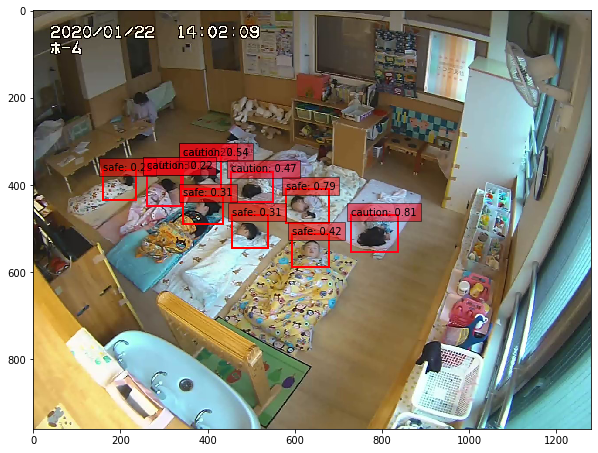

In [4]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "../data/annotation_data/val_anotation/sleep_check-PascalVOC-export/JPEGImages/10588047_01.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.2)#確信度の下限をいじると変わる



以上